# Exploration of Prediction of Trends in Stock Returns

---

In this project, I explore predicting trends in stock returns where machine learning is used to give a result of either "up" (1) or "down" (0) for every day that you predict. I have decided to use both LSTM and Random Forest to compare the both methods.

This project was a great and practical way to start learning machine learning whilst pursuing my interest in finance at the same time. Despite the outcomes not being great, I believe this is a good building block for my journey to continue learning machine learning and its applications in finance. The purpose of this project was getting a taste of machine learning and learning to use pandas, numpy, tensorflow and scikitlearn to analyze data and start learning on how to make models.

For future improvements, I could test other models, change the parameters and incorporate different technical indicators to see how it affects the accuracy; as well as reduce the risk for overfitting/underfitting. Finally, feature importance and correlation can be done to see which features actually affect the results and which do not, or are redundant.

This project was done by first collecting data of the stock GOOG from Yahoo Finance, exploring it and converting them to logarithmic returns. Then it was feature engineering consisting of RSI, MACD, Bollinger Bands and SMA. After, the data was split into training and testing data. Lastly, the LSTM and RF models were created and compared in their accuracy.

## Import of Needed Modules

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

## Showing the Data


---




In [ ]:
# Retrieve today's date and the date for 5 years ago
years = 10
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=years*365)).strftime('%Y-%m-%d')
# Retrieve the data about the stock from Yahoo Finance
stock = "GOOG"
stock_data = yf.download(stock, start=start_date, end=end_date)
# To make the dates to a column instead of an index
stock_data = stock_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [ ]:
# See the beginning and end of data to get an idea of how it looks like
stock_data.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
0,2014-12-22,26.077944,26.171646,26.250929,25.733349,25.733349,54475152
1,2014-12-23,26.362143,26.456863,26.654819,26.242451,26.277855,43952341
2,2014-12-24,26.271715,26.366112,26.515154,26.278851,26.452873,14118657
3,2014-12-26,26.533054,26.628391,26.639362,26.293312,26.366112,20810980
4,2014-12-29,26.349224,26.443897,26.700693,26.427992,26.536644,45570772


In [ ]:
stock_data.tail()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
2510,2024-12-12,193.630005,193.630005,196.705002,193.279999,196.300003,25197800
2511,2024-12-13,191.380005,191.380005,194.339996,191.259995,192.710007,18883200
2512,2024-12-16,198.160004,198.160004,200.639999,194.110001,194.365005,32248600
2513,2024-12-17,197.119995,197.119995,202.880005,196.690002,198.529999,24129500
2514,2024-12-18,190.149994,190.149994,198.690002,189.279999,196.830002,27554100


In [ ]:
# To see the amount of rows and columns
stock_data.shape

(2515, 7)

In [ ]:
# To see what kind of data type each column consists of
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           2515 non-null   datetime64[ns]
 1   (Adj Close, GOOG)  2515 non-null   float64       
 2   (Close, GOOG)      2515 non-null   float64       
 3   (High, GOOG)       2515 non-null   float64       
 4   (Low, GOOG)        2515 non-null   float64       
 5   (Open, GOOG)       2515 non-null   float64       
 6   (Volume, GOOG)     2515 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.7 KB


In [ ]:
# Mean, Standard Deviation, Percentiles, Min and Max
stock_data.describe()

Price,Date,Adj Close,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
count,2515,2515.000000,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,2019-12-20 21:46:01.192843008,82.005292,82.282352,83.115371,81.421325,82.232169,3.081932e+07
min,2014-12-22 00:00:00,24.472139,24.560070,24.730902,24.311253,24.664783,6.936000e+06
25%,2017-06-21 12:00:00,46.228148,46.394249,46.628250,46.077499,46.387251,2.123708e+07
50%,2019-12-19 00:00:00,63.790295,64.019501,64.665497,63.283501,63.811501,2.706000e+07
75%,2022-06-19 00:00:00,119.962460,120.393501,121.802998,119.410000,120.436874,3.569445e+07
max,2024-12-18 00:00:00,198.160004,198.160004,202.880005,196.690002,198.529999,2.232980e+08
std,NaN,44.093465,44.215646,44.697847,43.751232,44.198457,1.535930e+07


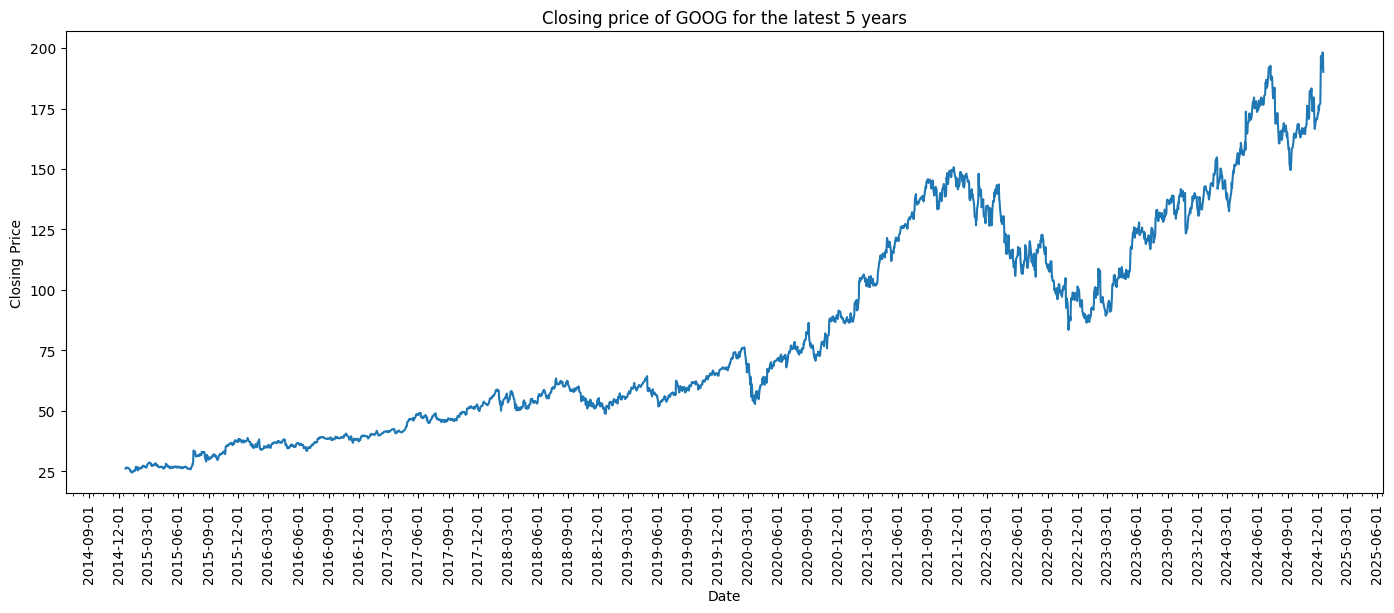

In [ ]:
# Graph over closing price
plt.figure(figsize=(17,6))

# Dates on x-axis and closing price on y-axis
plt.plot(stock_data["Date"], stock_data["Close"])
plt.title("Closing price of " + stock + " for the latest 5 years")
plt.xlabel("Date")
plt.ylabel("Closing Price")

# To prevent crowding of the x-axis labels, only labels of every third month is shown
# plt.gca() is used to retrieve the current axes
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))

# Reformat the dates to year-month-day
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Reformat the labels to vertical
plt.xticks(rotation=90)
plt.show()

## Editing of Data
---



### Logarithmic Returns

Logarithmic returns are logarithmic changes of the stock's price at two different time periods.

I have chosen to use logarithmic returns due to its statistical properties such as additive over time and has a more symmetrical distribution.

Logarithmic returns are calculated by:
ln(pt - pt-1) where pt is the final price at time period t and pt-1 is the price in the time period before.

In [ ]:
# Calculate log returns and put in as columns in the data
stock_data["log_return"] = np.log(stock_data["Adj Close"]) - np.log(stock_data["Adj Close"].shift(1))

# Remove null values and make changes in the data instead of making a copy
stock_data.dropna(inplace=True)

stock_data["log_return"].head()

,log_return
1,0.010839
2,-0.003436
3,0.009898
4,-0.006952
5,0.000170


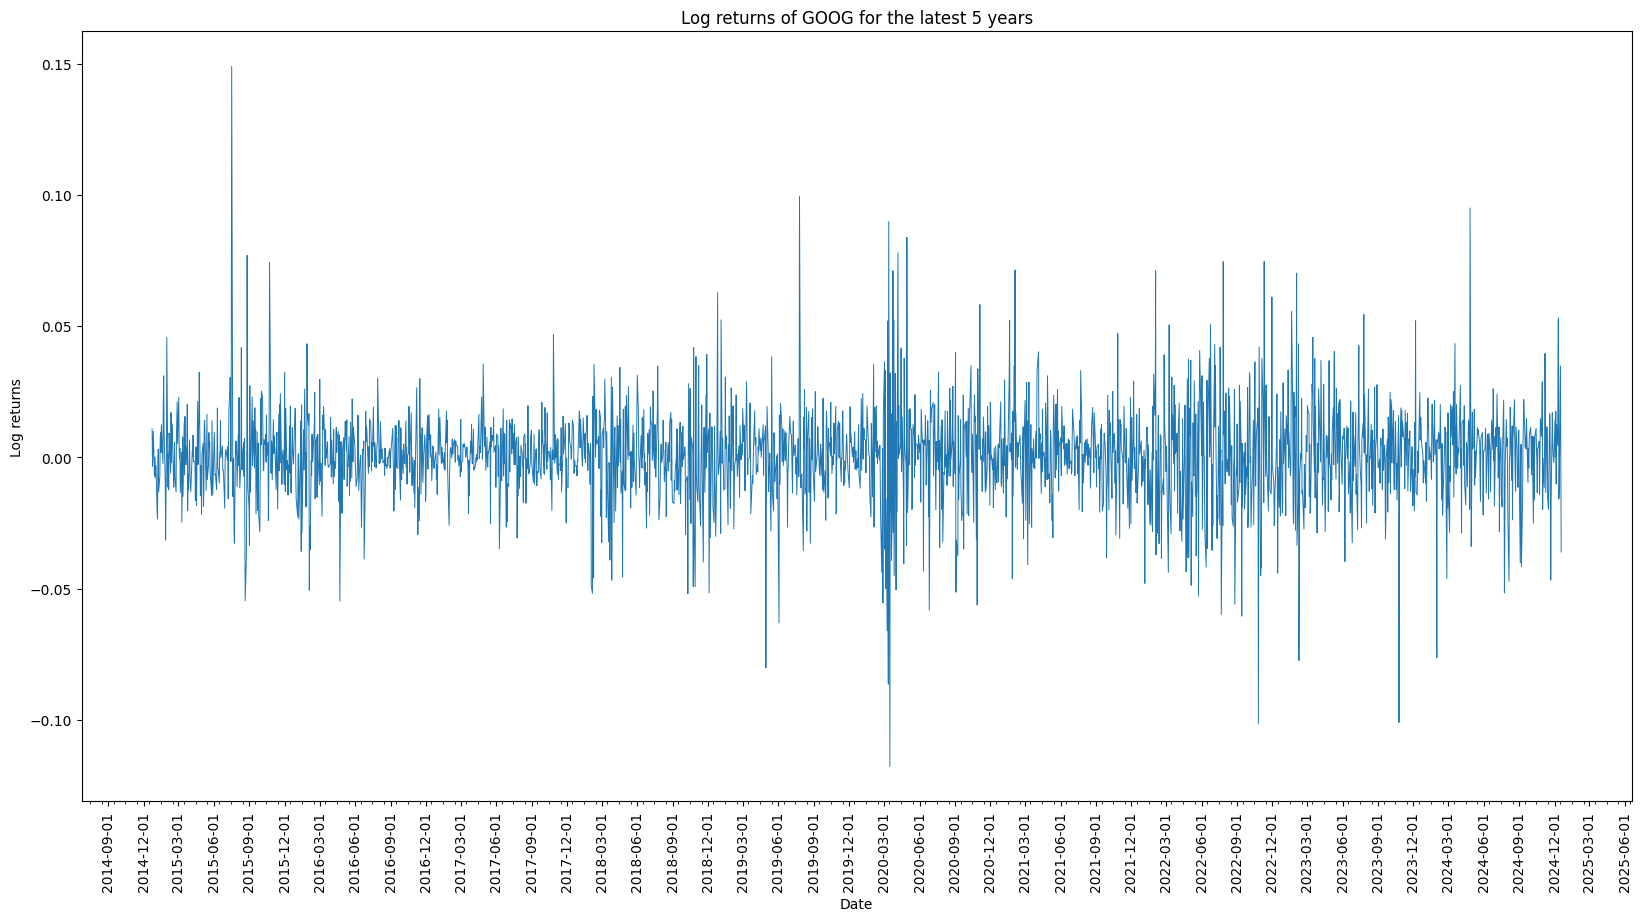

In [ ]:
# Graph over log returns
plt.figure(figsize=(20,10))

# Dates as x-axis and log returns as y-axis
plt.plot(stock_data["Date"], stock_data["log_return"], linewidth="0.7")
plt.title("Log returns of " + stock + " for the latest 5 years")
plt.xlabel("Date")
plt.ylabel("Log returns")

# To prevent crowding of the x labels, only labels of every third month is shown
# plt.gca() is used to retrieve the current axes
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))

# Reformat the dates to year-month-day
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Reformat the labels to vertical
plt.xticks(rotation=90)
plt.show()

### RSI (Relative Strength Index)


RSI compares the size of a stock's up moves and down moves and converts these to a number between 0 and 100. The time period is usually 14 days.

0 = Oversold, the buyers are pessimistic

100 = Overbought, the buyers are optimistic

RS = Mean of all up moves / Mean of all down moves

RSI = 100 - 100/(1+RS)

In [ ]:
# Difference is the calculated difference of a day in Adj Close
difference = stock_data["Adj Close"].diff(1)

# A copy of  difference is made for up moves and down moves in order to convert all negative values in up moves to 0 and all positive values in down moves to 0.
up = difference.copy()
down = difference.copy()
up[up < 0] = 0
down[down > 0] = 0

# Calculation of RSI
days = 14
average_increase = up.rolling(window=days).mean()
average_decrease = abs(down.rolling(window=days).mean())
RS = average_increase / average_decrease
RSI = 100 - (100/(1+RS))

# Inserting RSI as a column in the data
# First 14 values will be NaN due to the requirement of at least 14 days of data to calculate RSI
stock_data["RSI"] = RSI
stock_data["RSI"].head(28)

,RSI
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN
10,NaN


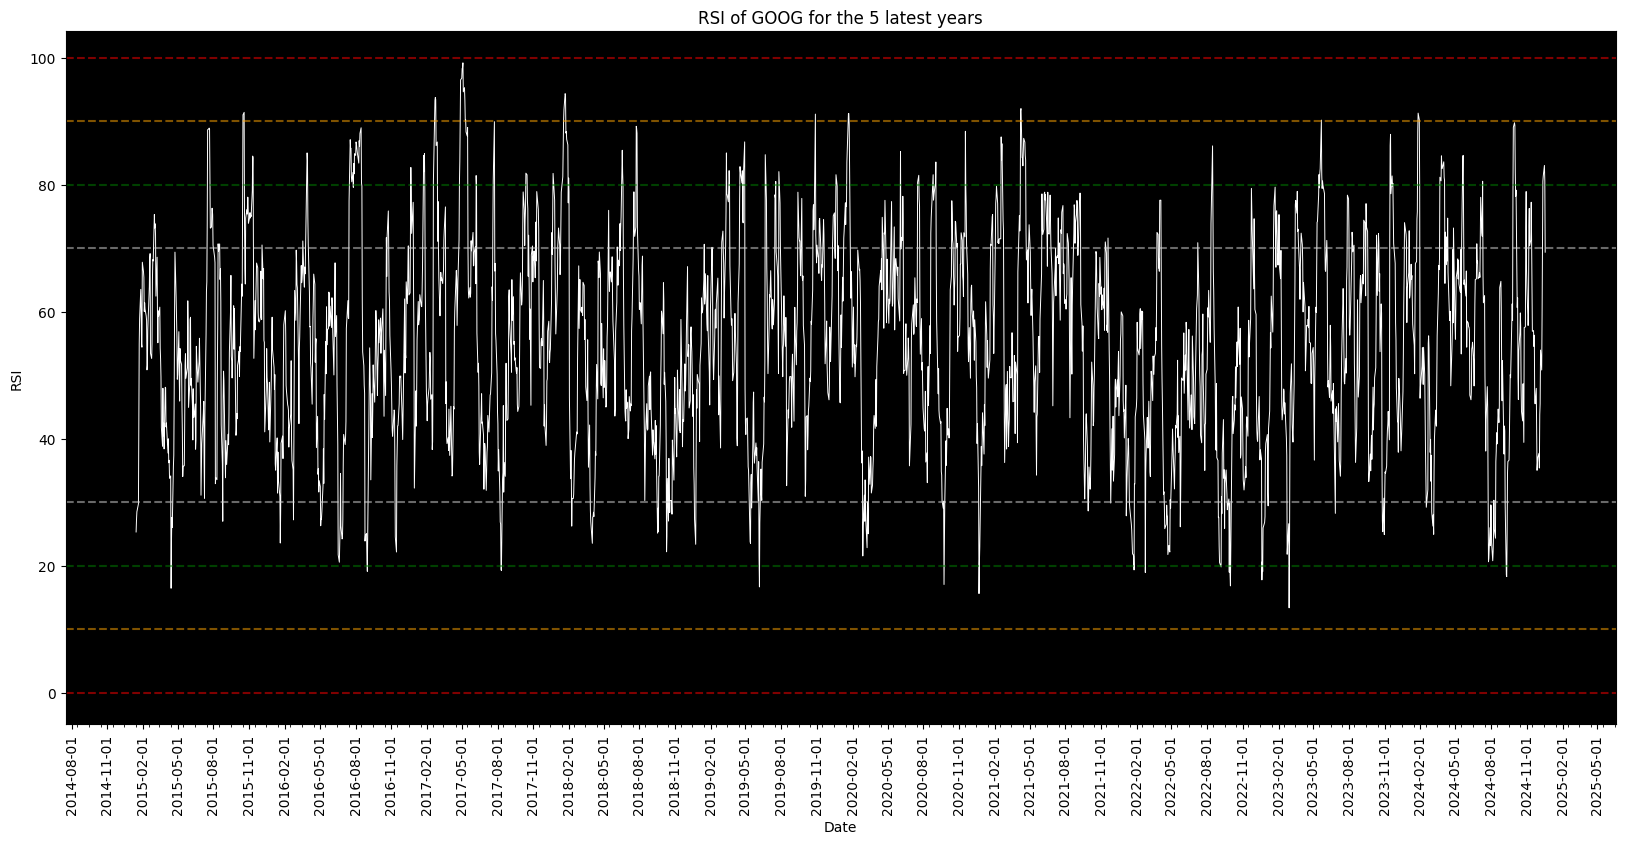

In [ ]:
# plotting the RSI
plt.figure(figsize=(20,9))

# Date as x-axis och RSI as y-axis
plt.plot(stock_data["Date"], stock_data["RSI"], linewidth="0.7", color="white")
plt.title("RSI of " + stock + " for the 5 latest years")
plt.xlabel("Date")
plt.ylabel("RSI")

# Make the background to black
# plt.gca() is used to retrieve the current axes
ax = plt.gca()
ax.set_facecolor("black")

# Draw out lines to see more clearly, e.g. where 100 is overbought and 0 oversold
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.axhline(10, color='orange', linestyle='--', alpha=0.5)
ax.axhline(20, color='green', linestyle='--', alpha=0.5)
ax.axhline(30, color='lightgray', linestyle='--', alpha=0.5)
ax.axhline(70, color='lightgray', linestyle='--', alpha=0.5)
ax.axhline(80, color='green', linestyle='--', alpha=0.5)
ax.axhline(90, color='orange', linestyle='--', alpha=0.5)
ax.axhline(100, color='red', linestyle='--', alpha=0.5)

# To prevent crowding of the x-labels, only labels of every third month is shown
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))

# Reformat the dates to year-month-day
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Reformat the labels to vertical
plt.xticks(rotation=90)
plt.show()

### MACD (Moving Average Convergence Divergence)

MACD is a technical indicator collecting data from different moving averages to detect changes in the momentum of the stock price.

Convergence = two moving averages are met

Divergence = the moving averages are moving from each other

We calculate the exponential moving averages (EMA) for 12 days and 26 days. With these values we calculate:
- MACD-line: ema_12 - ema_26 (the distance between them)
- Signal-line: ema_9 of the MACD line (Identifies changes in price momentum)

In [ ]:
# Calculation of EMA of 12 and 26 days using pandas
# if adjust=True the first values would have been based on less data points, not the whole "span"
ema_12 = stock_data["Adj Close"].ewm(span=12, adjust=False).mean()
ema_26 = stock_data["Adj Close"].ewm(span=26, adjust=False).mean()

# Calculation of the MACD line
MACD_line = ema_12 - ema_26

# Calculation of EMA of 9 days of the MACD line
signal_line = MACD_line.ewm(span=9, adjust=False).mean()

# Input of MACD och Signal as columns in stock_data
stock_data["MACD"] = MACD_line
stock_data["Signal"] = signal_line

stock_data["Signal"].head()

,Signal
1,0.000000
2,-0.001443
3,0.000459
4,0.001423
5,0.001816


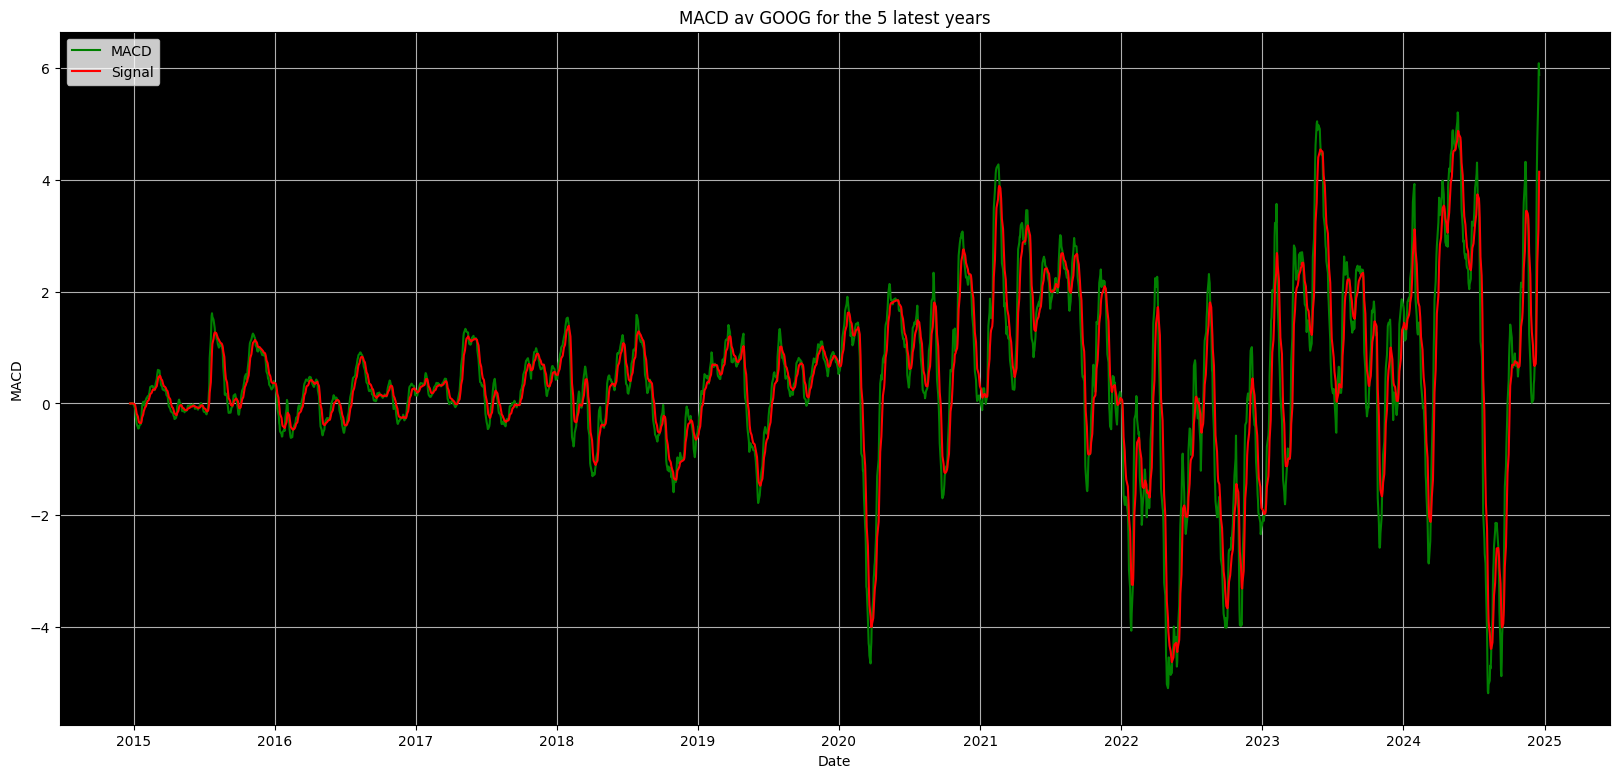

In [ ]:
# plot the MACD_line and signal_line
plt.figure(figsize=(20,9))
plt.xlabel("Date")
plt.ylabel("MACD")

# Date as x-axis and MACD as y-axis
plt.plot(stock_data["Date"], stock_data["MACD"], color="green", label="MACD")

# Date as x-axis and Signal as y-axis
plt.plot(stock_data["Date"], stock_data["Signal"],  color="red", label="Signal")

# Reformat the dates to year-month-day
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Make the background to black
# plt.gca() is used to retrieve the current axes
ax = plt.gca()
ax.set_facecolor("black")

# To get a grid
plt.grid(True)
plt.title("MACD av " + stock + " for the 5 latest years")

# To show what line belongs to MACD and what line belongs to Signal
plt.legend()
plt.show()

### SMA (Simple Moving Average)


The SMA is the average of closing prices in a period.

SMA for 10 days is used to decide the trend in the short-run

SMA for 50 days is used to decide the intermediate trend

SMA for 200 days is used to decide the trend in the long-run

In [ ]:
# Calculation of SMA 10, 50 and 200
SMA_10 = stock_data["Adj Close"].rolling(window=10).mean()
SMA_50 = stock_data["Adj Close"].rolling(window=50).mean()
SMA_200 = stock_data["Adj Close"].rolling(window=200).mean()

# Input of these SMAs into columns in stock_data
stock_data["SMA_10"] = SMA_10
stock_data["SMA_50"] = SMA_50
stock_data["SMA_200"] = SMA_200

stock_data["SMA_10"].tail()

,SMA_10
2510,179.616768
2511,181.725089
2512,184.262691
2513,186.692296
2514,188.118250


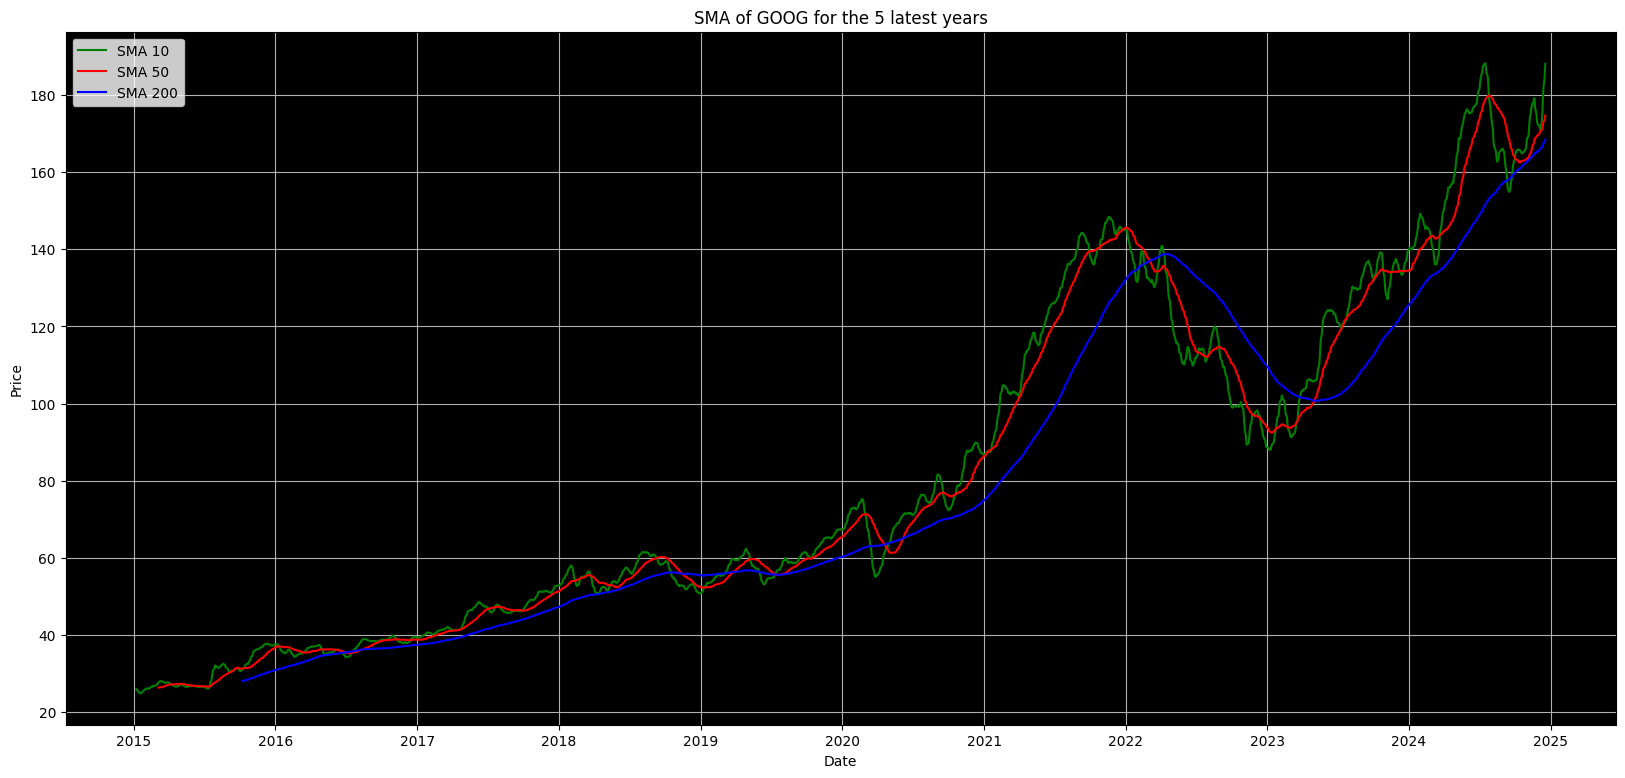

In [ ]:
# Plotting the SMAs
plt.figure(figsize=(20,9))
plt.xlabel("Date")
plt.ylabel("Price")

# Date as x-axis and every SMA as y-axis
plt.plot(stock_data["Date"], stock_data["SMA_10"], color="green", label="SMA 10")
plt.plot(stock_data["Date"], stock_data["SMA_50"], color="red", label="SMA 50")
plt.plot(stock_data["Date"], stock_data["SMA_200"], color="blue", label="SMA 200")

# Reformat the dates to year-month-day
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Make the background to black
# plt.gca() is used to retrieve the current axes
ax = plt.gca()
ax.set_facecolor("black")

# To get a grid
plt.grid(True)

plt.title("SMA of " + stock + " for the 5 latest years")

# To show which line belongs to which SMA
plt.legend()
plt.show()

### Bollinger-bands

Bollinger-bands is a indicator used for volatility. It is constructed with a SMA in the middle, an upper band and a lower band that are configured on two standard deviations from SMA. SMA for 20 days is typically used.

The broader distance between the bands, the more volatile it is and the narrower, the more stable it is.

Upper band is calculated by adding the SMA for 20 days with 2 times the standard deviation for 20 days and for the lower band the SMA for 20 days is subtracted with 2 times the standard deviation for 20 days.

In [ ]:
# Calculation of SMA_20, standard deviation for 20 days, upper band and lower band
SMA_20 = stock_data["Adj Close"].rolling(window=20).mean()
STD_20 = stock_data["Adj Close"].rolling(window=20).std()
upper_band = SMA_20 + 2 * STD_20
lower_band = SMA_20 - 2 * STD_20

# Calculation of difference between closing prices and lower band and upper band
upper_difference = stock_data["Adj Close"] - upper_band
lower_difference = stock_data["Adj Close"] - lower_band

# Differences and SMA_20 input as columns in the stock data
stock_data["upper_difference"] = upper_difference
stock_data["lower_difference"] = lower_difference
stock_data["SMA_20"] = SMA_20
stock_data["upper_difference"].tail()

,upper_difference
2510,1.624260
2511,-2.727986
2512,0.486121
2513,-3.307046
2514,-11.369888


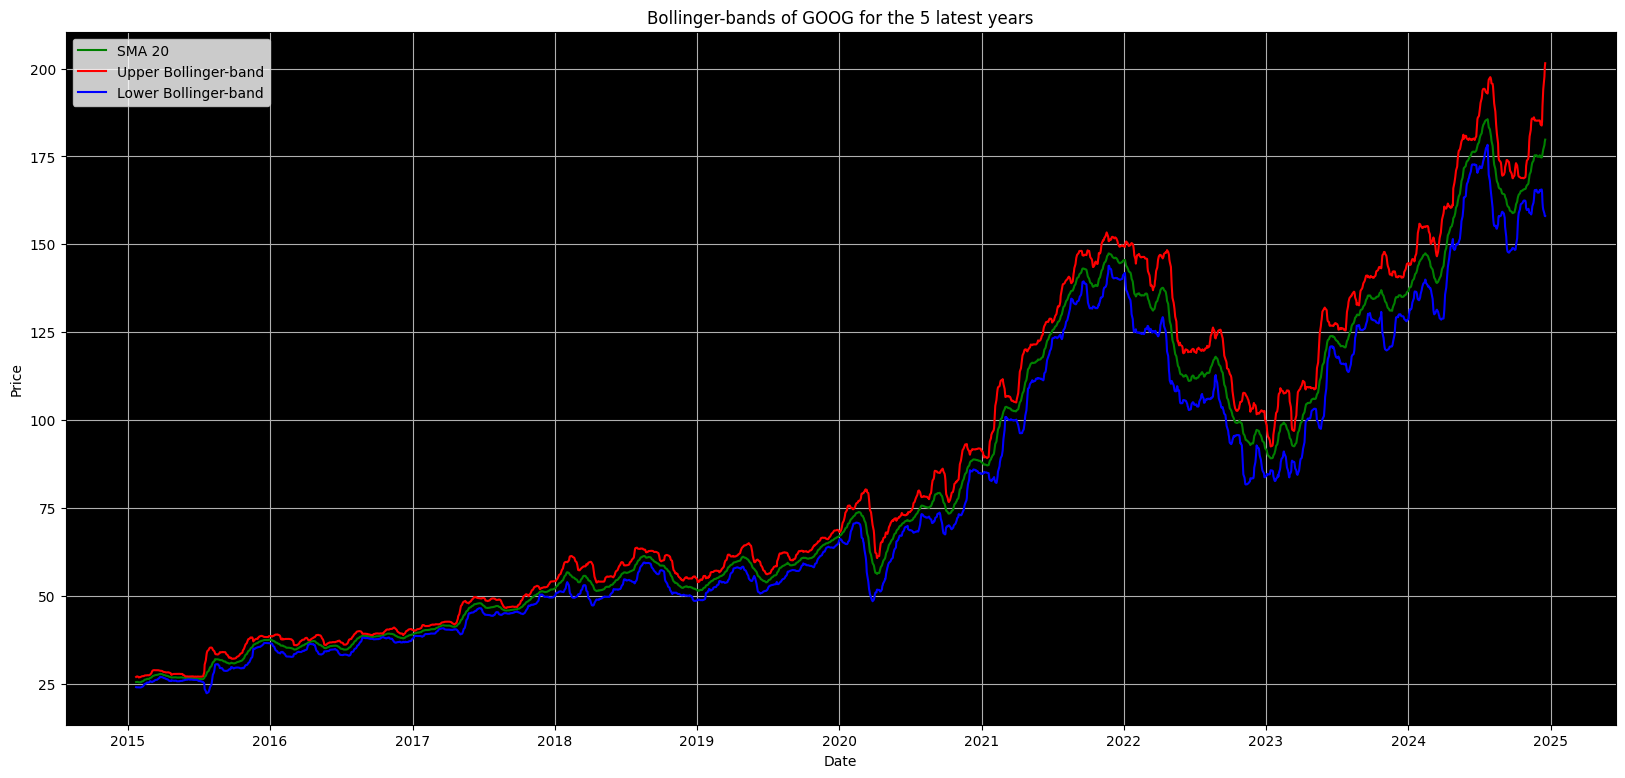

In [ ]:
# plotting Bollinger-bands
plt.figure(figsize=(20,9))
plt.xlabel("Date")
plt.ylabel("Price")

# Date as x-axis and SMA_20 as y-axis
plt.plot(stock_data["Date"], stock_data["SMA_20"],  color="green", label="SMA 20")

# Date as x-axis and respective band as y-axis
plt.plot(stock_data["Date"], upper_band,  color="red", label="Upper Bollinger-band")
plt.plot(stock_data["Date"], lower_band,  color="blue", label="Lower Bollinger-band")

# Reformat the dates to year-month-day
date_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(date_fmt)

# Make the background to black
# plt.gca() is used to retrieve the current axes
ax = plt.gca()
ax.set_facecolor("black")

# To get a grid
plt.grid(True)
plt.title("Bollinger-bands of " + stock + " for the 5 latest years")

# To show which line belongs to which (SMA or the respective bands)
plt.legend()
plt.show()

In [ ]:
# To see now how the data looks like after the input of all technical indicators
stock_data.tail()

Price,Date,Adj Close,Close,High,Low,Open,Volume,log_return,RSI,MACD,Signal,SMA_10,SMA_50,SMA_200,upper_difference,lower_difference,SMA_20
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG,,,,,,,,,,
2510,2024-12-12,193.630005,193.630005,196.705002,193.279999,196.300003,25197800,-0.015781,80.505342,4.205114,1.961012,179.616768,172.482829,167.239671,1.624260,33.052209,176.291770
2511,2024-12-13,191.380005,191.380005,194.339996,191.259995,192.710007,18883200,-0.011688,81.347185,4.685197,2.505849,181.725089,172.970018,167.500173,-2.727986,31.481358,177.003319
2512,2024-12-16,198.160004,198.160004,200.639999,194.110001,194.365005,32248600,0.034814,83.018064,5.548792,3.114438,184.262691,173.565839,167.803045,0.486121,39.380543,178.226672
2513,2024-12-17,197.119995,197.119995,202.880005,196.690002,198.529999,24129500,-0.005262,80.577545,6.079200,3.707390,186.692296,174.224164,168.120047,-3.307046,39.041660,179.252689
2514,2024-12-18,190.149994,190.149994,198.690002,189.279999,196.830002,27554100,-0.035999,69.361380,5.869471,4.139806,188.118250,174.716920,168.404292,-11.369888,32.087148,179.791364


## Preparation of Data

---




The data is prepared in order to be able to be inserted in LSTM and Random Forest. Data that is not used is removed and the rest of the data is scaled and divided into training data and test data.

In [ ]:
# Make a copy of the data
stock_data2 = stock_data

# Remove the values that are not needed
stock_data2 = stock_data2.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1)

# Remove null values, this will lead however to a loss of 200 days
stock_data2.dropna(inplace=True)
stock_data2.head()

<ipython-input-27-ac1bb5ae42d9>:5: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  stock_data2 = stock_data2.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1)


Price,Date,log_return,RSI,MACD,Signal,SMA_10,SMA_50,SMA_200,upper_difference,lower_difference,SMA_20
Ticker,,,,,,,,,,,
200,2015-10-08,-0.004994,54.486224,0.184473,0.032704,30.973110,31.302586,28.088895,-0.833960,2.167920,31.176604
201,2015-10-09,0.006938,53.757746,0.230038,0.072171,31.130744,31.313567,28.117410,-0.708421,2.396909,31.221045
202,2015-10-12,0.004743,62.108663,0.275276,0.112792,31.388717,31.334551,28.147140,-0.673947,2.550606,31.279410
203,2015-10-13,0.008669,64.350123,0.329958,0.156225,31.674341,31.355566,28.176966,-0.519979,2.872134,31.322156
204,2015-10-14,-0.001749,62.428916,0.364509,0.197882,31.887276,31.377398,28.207427,-0.681090,2.844015,31.359970


In [ ]:
# Create a target variable for the trends in log returns, the changes in log returns from one day to another
stock_data2["Target"] = stock_data["log_return"].shift(-1)

# Create a variable where the changes are classified as 1 (up) or 0 (down) with an anonymous function as it is only used once
stock_data2["Target_Class"] = stock_data2["Target"].apply(lambda x: 1 if x > 0 else 0)

# Scale the log returns with standardization
scale1 = StandardScaler()
# stock_data2["log_return"] is converted to a column vector with reshape because fit_transform expects this
stock_data2["log_return_standard"] = scale1.fit_transform(stock_data2["log_return"].values.reshape(-1,1))

# Scale the leftover data
leftover = stock_data2[["RSI", "MACD", "Signal", "SMA_10", "SMA_20", "SMA_50", "SMA_200", "upper_difference", "lower_difference"]]
stock_data2[["RSI_standard", "MACD_standard", "Signal_standard", "SMA_10_standard", "SMA_20_standard", "SMA_50_standard", "SMA_200_standard", "upper_standard", "lower_standard"]] = scale1.fit_transform(leftover)

# Decide input and output
X = stock_data2[["RSI_standard", "MACD_standard", "Signal_standard", "SMA_10_standard", "SMA_20_standard", "SMA_50_standard", "SMA_200_standard", "upper_standard", "lower_standard", "log_return_standard"]]
Y = stock_data2["Target_Class"].values

# Split the data into training data and test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Implementation of Random Forest

---



**Decision Trees**

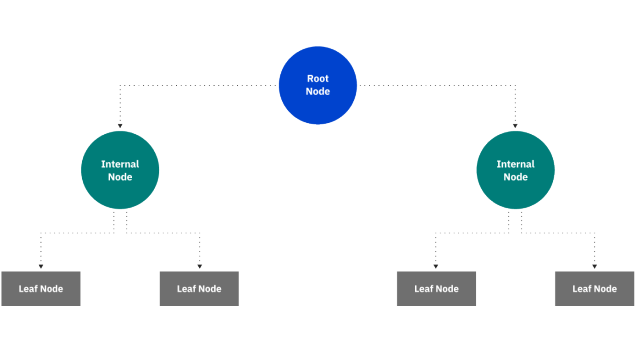

Decision trees have a hierarchical tree structure with a root node, internal nodes, branches and leaf nodes. The outgoing branches from the root node are then fed into the internal nodes, also known as decision nodes. The nodes perform evaluations to form homogeneous sets (leaf nodes) which then represent all possible outcomes. Decision trees then identify the optimal split points in a tree.

**Random Forest Classifier**

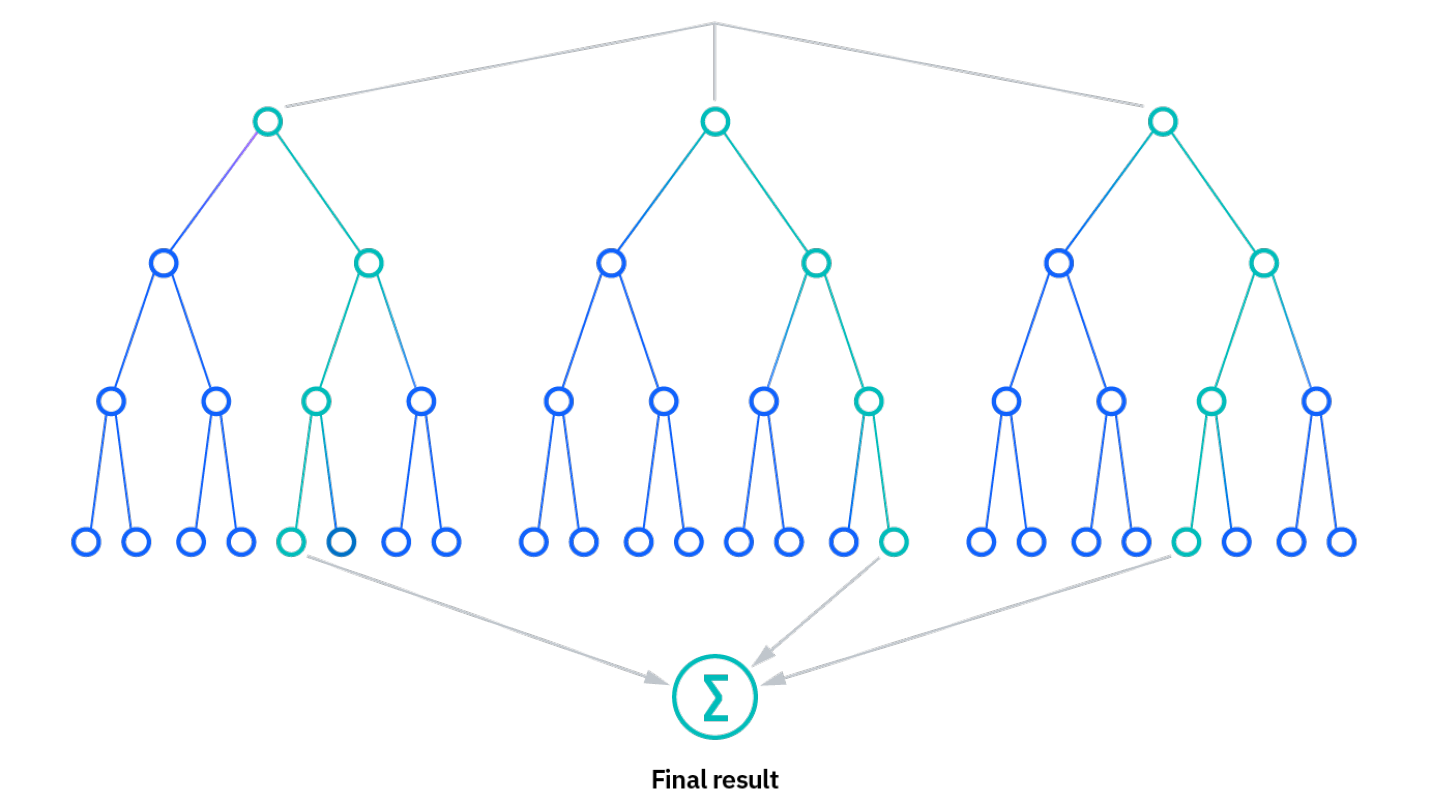

RF consists of a large number of individual decision trees that act as an ensemble where each tree outputs a class prediction and the class with the "most votes" becomes the model's prediction.

They have low correlation with each other and therefore protect themselves from each other's errors which is favorable. RF also has a reduced risk of "overfitting". However, it requires more resources and is more complex.

In [ ]:
# Create and train the Random Forest model
rf = RandomForestClassifier()

# Number of trees
n_estimators = [100, 200, 300]

# Maximum amount of levels in a tree
max_depth = [5, 10, 15, None]

# Minimum amount of examples required to split a node
min_samples_split = [50, 100, 150, 200]

# Minimum amount of examples required for a leaf node
min_samples_leaf = [1, 2, 4, 8]

# Number of features randomized on each split
# Sqrt means the number of functions randomized at each division is the square root of the number
# Auto is all functions, no restrictions
max_features = [None]

# Method for choosing examples to train the trees
# True means that each tree is trained on a random sample of the data set
# False means that each tree is trained on the entire data set
bootstrap = [True, False]

# Respects sequential nature of time series data and splits the data based on time, preventing leakage
tscv = TimeSeriesSplit(n_splits=5)

# a grid variable consisting of all these above values
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'random_state': [1]}
print(param_grid)

{'n_estimators': [100, 200, 300], 'max_features': [None], 'max_depth': [5, 10, 15, None], 'min_samples_split': [50, 100, 150, 200], 'min_samples_leaf': [1, 2, 4, 8], 'bootstrap': [True, False], 'random_state': [1]}


In [ ]:
# RandomizedSearchCV performs a randomized search over the specified parameter grid to find the best hyperparameters
# n_jobs is how many "jobs" are executed in parallel
# verbose specifies the verbose level of output during the search
# cv = number of cross-validations
# random_state to ensure the same randomization when running the code
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv = tscv, verbose = 2, n_jobs = 4, random_state=0)
rf_random.fit(X_train, Y_train)

# Make a prediction on test data
rf_y_pred = rf_random.predict(X_test)
rf_accuracy = accuracy_score(Y_test, rf_y_pred)
print(rf_accuracy)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.5334773218142549


In [ ]:
# To see the optimized parameters
rf_random.best_params_

{'random_state': 1,
 'n_estimators': 100,
 'min_samples_split': 200,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 5,
 'bootstrap': False}

In [ ]:
# Predictions for the test data are printed out
print(rf_y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]


In [ ]:
# Make predictions on training data
rf_train_pred = rf_random.predict(X_train)

# Calculate accuracy on training data
rf_train_accuracy = accuracy_score(Y_train, rf_train_pred)
print(rf_train_accuracy)

0.5583153347732182


The train accuracy is slightly higher than the test accuracy with around +0.025.

Low accuracies show underperformance which is expected for my first attempt.

**Suggestions for Improvement:**

* The various parameters in param_grid could be adjusted and experimented to see  if there are any changes in the accuracies.
* For next attempt, looking at the feature importance and correlation of each feature could be useful in order to remove unneccessary features.



## Implementation of LSTM

---



image.png

**RNN (recurrent neural network)**

RNNs are a class of artificial neural networks that deal with sequential data. They have a memory of previous inputs and data and can thus find patterns.

**LSTM (Long Short-Term Memory)**

LSTM is a type of RNN that can keep a memory of the data for longer time periods than RNN and can selectively remember or forget information from previous time periods.

In [ ]:
# To check the size of the training data
X_train.size

18520

In [ ]:
# Reshape train and test of X so that it fits LSTM, I choose to have 30 days of data as sequence
sequence = 30

# The training data is split into these sequences
# Modulo is calculated so that the data can be divided into exact numbers of sequences
# Timeseriesgenerator creates these sequences to feed into LSTM
modulo = len(X_train) % sequence
sequence2 = sequence - modulo
split_X_train = X_train[:-(len(X_train) % sequence)]
split_Y_train = Y_train[:-(len(Y_train) % sequence)]
generator = TimeseriesGenerator(split_X_train, split_Y_train, length=sequence2, batch_size=32)

# Validation generator to evaluate the model with residual data
val_X_train = X_train[-(len(X_train) % sequence):]
val_Y_train = Y_train[-(len(Y_train) % sequence):]
val_generator = TimeseriesGenerator(val_X_train, val_Y_train, length=sequence2, batch_size=32)

# Build the LSTM model
# Sigmoid is used to get only 1 or 0 as an answer
# Sequential means a linear stack of layers
# Dropout means that the data is "dropped" to reduce the risk of overfitting
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence2, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation="sigmoid"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
# EarlyStopping is used to reduce the risk of overfitting, stops when the accuracy continues downward after 20 epochs
early_stop = EarlyStopping(monitor="val_loss", verbose=1, patience=20)
model.fit(generator, epochs=200, batch_size=32, validation_data=val_generator, callbacks=[early_stop])

# Evaluate model accuracy
test_generator = TimeseriesGenerator(X_test, Y_test, length=sequence2, batch_size=32)
model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.4746 - loss: 0.7058 - val_accuracy: 0.6429 - val_loss: 0.6636
Epoch 2/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5547 - loss: 0.6894 - val_accuracy: 0.7143 - val_loss: 0.6613
Epoch 3/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5437 - loss: 0.6889 - val_accuracy: 0.6429 - val_loss: 0.6441
Epoch 4/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5641 - loss: 0.6829 - val_accuracy: 0.7143 - val_loss: 0.6808
Epoch 5/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5389 - loss: 0.6896 - val_accuracy: 0.7143 - val_loss: 0.6631
Epoch 6/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5775 - loss: 0.6806 - val_accuracy: 0.7143 - val_loss: 0.6693
Epoch 7/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5598 - loss: 0.6854 - val_accuracy: 0.7143 - val_loss: 0.6645
Epoch 8/200
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5770 - loss: 0.6821 - val_accuracy: 0.6429 - val_

[0.7218888401985168, 0.5406593680381775]

In [ ]:
# LSTM makes a prediction of the testdata
LSTM_y_pred = model.predict(test_generator)

# The prediction from the LSTM is originally in how likely it is to be 1 (up), so it is converted to 0 and 1
pred_binary = np.where(LSTM_y_pred > 0.5, 1, 0)

print(pred_binary)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
[[0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]


## Comparisons of the accuracy

---



### Naive Forecast

Naive Forecast is a method where it is assumed that the forecast for a given period is the same as the value observed in the previous period. I have chosen to compare my models with naive forecast to see if they can beat such a common and simple forecasting method.

In [ ]:
# Naive forecast

# If the price increased compared to the previous day, 1 is added to the forecast, otherwise 0
def naive_forecast(data=stock_data2["Target_Class"]):
    forecast = []
    for i in range(1, len(data)):
        if data[i-1] > 0:
            forecast.append(1)
        else:
            forecast.append(0)
    return forecast

naive_pred = naive_forecast(Y_test)

# LSTMS accuracy is previously stated in model.evaluate
naive_acc = accuracy_score(Y_test[1:], naive_pred)
rf_accuracy = accuracy_score(Y_test, rf_y_pred)
print("Naive: ", naive_acc, " RF: ", rf_accuracy)

Naive:  0.5108225108225108  RF:  0.5334773218142549


### ROC AUC (Receiver Operating Characteristic Area Under the Curve) score

The ROC AUC score is a way to evaluate the performance of a classification model. ROC is a probability curve and AUC represents the degree or measures of separability. It tells how much the model can differentiate between classes.

In [ ]:
LSTM_rocacc = roc_auc_score(Y_test[sequence2:], LSTM_y_pred)
naive_rocacc = roc_auc_score(Y_test[1:], naive_pred)
rf_rocacc = roc_auc_score(Y_test, rf_y_pred)
print("LSTM: ",LSTM_rocacc, " Naive: ", naive_rocacc, " RF: ",rf_rocacc)

LSTM:  0.5121784345922276  Naive:  0.5059244397334949  RF:  0.4874151583710407


### Classification Report

Classification report is used to assess the quality of the predictions from a classification algorithm.

TP - True Positive

FP - False Positive

FN - False Negative

Precision = the accuracy of 1 (up) predictions = TP/(TP + FP)

% of correct positive predictions relative to total positive predictions

Recall = What percentage of the 1 (up) predictions caught it = TP / ( TP + FN )

% of correct positive predictions relative to total actual positives

F1-score = weighted average between precision and recall= 2*(Recall * Precision) / (Recall + Precision)

Score needs to be close to 1

In [ ]:
# Classification reports of LSTM, naive forecast och RF
LSTM_classification_report = classification_report(Y_test[sequence2:], pred_binary)
naive_classification_report = classification_report(Y_test[1:], naive_pred)
rf_classification_report = classification_report(Y_test, rf_y_pred)
print("LSTM: ",LSTM_classification_report, " Naive: ",naive_classification_report, " RF: ", rf_classification_report)

LSTM:                precision    recall  f1-score   support

           0       0.48      0.31      0.37       203
           1       0.57      0.73      0.64       252

    accuracy                           0.54       455
   macro avg       0.52      0.52      0.51       455
weighted avg       0.53      0.54      0.52       455
  Naive:                precision    recall  f1-score   support

           0       0.46      0.46      0.46       208
           1       0.56      0.56      0.56       254

    accuracy                           0.51       462
   macro avg       0.51      0.51      0.51       462
weighted avg       0.51      0.51      0.51       462
  RF:                precision    recall  f1-score   support

           0       0.32      0.03      0.06       208
           1       0.54      0.94      0.69       255

    accuracy                           0.53       463
   macro avg       0.43      0.49      0.38       463
weighted avg       0.44      0.53      0.41       46

### Confusion Matrix

Confusion matrix is a way to evaluate the performance of machine learning models in classifying. It is actually a table with 4 different combinations of predicted and actual values.

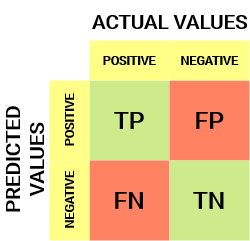

So true negatives are the number of times the model has correctly predicted that it is a downturn and false negatives are then the number of times it has predicted that it is a downturn but it is not correct.

True positives are the number of times the model has correctly predicted that it is a rise and false positives are the number of times it has predicted that it is a rise but it is not correct.

In [ ]:
# Calculation of confusion matrix
LSTM_confusion_matrix = confusion_matrix(Y_test[sequence2:], pred_binary)
naive_confusion_matrix = confusion_matrix(Y_test[1:], naive_pred)
rf_confusion_matrix = confusion_matrix(Y_test, rf_y_pred)
print("LSTM: ",LSTM_confusion_matrix, " Naive: ",naive_confusion_matrix, " RF: ",rf_confusion_matrix)


LSTM:  [[ 62 141]
 [ 68 184]]  Naive:  [[ 95 113]
 [113 141]]  RF:  [[  7 201]
 [ 15 240]]


### Conclusion

With the results from the confusion matrix, classification report, roc auc, naive forecast and the trends from LSTM and random tree, we can see that

* Both LSTM and RF had a slightly higher accuracy than Naive Forecast which is positive.

* With the low ROC AUC score of slightly above 0.5, it shows LSTM has some predictive power, but it is very small, showing the need for improvements and tuning the model. RF's ROC AUC score below 0.5 is not good, again showing the need for improvements.

* From the classification report, we can see that both LSTM and RF did a poor job at predicting, as seen in the low F-scores and the precision and recall scores.

* In the confusion matrix, we can clearly see the poor performance of the RF model, only getting a few correct predictions.



---



**Suggestions for Improvement for Both Models:**
* Feature Engineering: Find out which features have the most importance and remove those who are not relevant or are redundant. Find other features that may be relevant to add. Remove any potential noisy data.

* Hyperparameter Tuning: Experiment and adjust the various parameters and see if they make any improvements

* Model Architecture: It could be useful to find out if Gradient Boosting does a better job than RF and to change the layers in the LSTM and see if that leads to any improvements.